In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mahdimashayekhi/fake-news-detection-dataset")
 # opendatasets so that the dataset can be loaded into code easily without downloading

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ggggg
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mahdimashayekhi/fake-news-detection-dataset


100%|██████████| 11.2M/11.2M [00:00<00:00, 1.27GB/s]

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [48]:
df=pd.read_csv("/content/fake-news-detection-dataset/fake_news_dataset.csv")
df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [49]:
all_authors=list(df['author'].unique())
len(all_authors)

17052

In [50]:
all_categories=list(df['category'].unique())
len(all_categories)

7

In [51]:
all_categories

['Politics',
 'Business',
 'Science',
 'Technology',
 'Health',
 'Sports',
 'Entertainment']

In [52]:
df['category'].value_counts()

,count
category,
Health,2922
Entertainment,2889
Technology,2882
Sports,2867
Business,2849
Politics,2802
Science,2789


In [53]:
df.columns = df.columns.str.strip()  # remove leading/trailing spaces
print(df.columns)  # verify


Index(['title', 'text', 'date', 'source', 'author', 'category', 'label'], dtype='object')


In [56]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)
articles_per_day = df.groupby('date').size()
articles_per_day.head()

,0
date,
2022-04-26,22
2022-04-27,19
2022-04-28,15
2022-04-29,16
2022-04-30,20


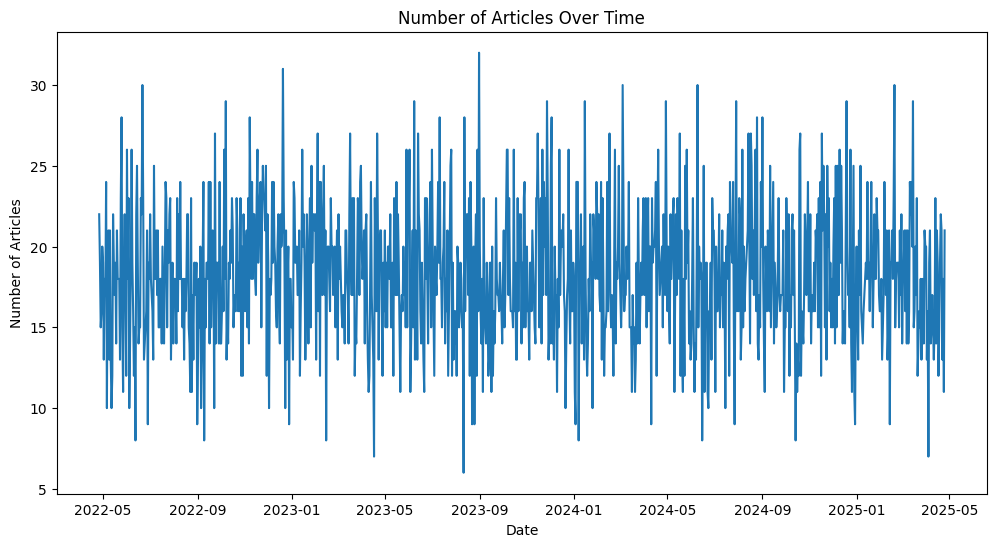

In [57]:
plt.figure(figsize=(12,6))
plt.plot(articles_per_day.index, articles_per_day.values)
plt.title("Number of Articles Over Time")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()

In [9]:
df = df[['text', 'label']]    # since we are going to make prediction only upon text. other columns like author, source are not meaningfull for predictions
df.dropna(inplace=True)  # rows with null values are useless, so remove them

In [10]:
df.head()

,text,label
0,more tax development both store agreement lawy...,real
1,probably guess western behind likely next inve...,fake
2,them identify forward present success risk sev...,fake
3,phone which item yard Republican safe where po...,fake
4,wonder myself fact difficult course forget exa...,fake


In [11]:
df['label'] = df['label'].map({'fake': 0, 'real': 1})

In [12]:
df['label'].unique()

array([1, 0])

In [13]:
df.head()

,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone which item yard Republican safe where po...,0
4,wonder myself fact difficult course forget exa...,0


In [14]:
stop_words = set([
    "the","and","is","in","to","a","of","for","on","with","as","by",
    "at","an","this","that","it","from","be","has","was","are","or",
    "but","its","have","they","their","will","can","which","about"
])

In [15]:
def clean_text(text):
    text = str(text).lower()
    cleaned_words = []
    for word in text.split():
        # keep only alphabetic words longer than 2 chars and not in stop words
        word = ''.join([c for c in word if 'a' <= c <= 'z'])
        if len(word) > 2 and word not in stop_words:
            cleaned_words.append(word)
    return ' '.join(cleaned_words)

df['text'] = df['text'].apply(clean_text)

In [16]:
df.head()

,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone item yard republican safe where police i...,0
4,wonder myself fact difficult course forget exa...,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42
)

In [18]:
def build_vocab(texts):
    vocab = {}
    index = 0
    for text in texts:
        for word in text.split():
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab

In [19]:
vocab = build_vocab(X_train)
vocab_size = len(vocab)
print(f"Vocabulary size after cleaning: {vocab_size}")

Vocabulary size after cleaning: 928


In [20]:
X_train[3]

'road listen add question main head worker general source report cold process training provide bag election she visit lawyer security store product relate consumer inside above economic box notice nice phone until color edge month situation development realize relate several determine rule man visit main level politics people mind out would who ever able miss rule one down set around throw war full job several issue just force film manager very pass animal none stay age reason bank town team already near left husband suffer natural stock instead environment indicate provide including soldier cup others effect focus realize son identify inside finally middle decide degree whom mention hear stay music consumer beautiful kind each court painting billion health money thus what conference pay provide purpose long five same worker site another week mean test give benefit land need season factor positive partner whatever discover mission determine area health oil partner control benefit task 

In [21]:
len(X_train)

16000

In [22]:
df.shape[0]*0.8

16000.0

In [23]:
def compute_tf(texts, vocab):
    tf = np.zeros((len(texts), len(vocab))) # tf is like a matrix of size 16000*928 (928 is vocab size)
    for i, text in enumerate(texts):
        words = text.split()
        for word in words:
            if word in vocab:
                tf[i, vocab[word]] += 1
        # if len(words) > 0:
        #     tf[i] = tf[i] / len(words)
    return tf

In [24]:
tf_train = compute_tf(X_train, vocab)

In [25]:
tf_train[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 3., 2., 1.,
       2., 4., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 3., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [26]:
def compute_idf(texts, vocab):
    idf = np.zeros(len(vocab))
    N = len(texts)
    for word, idx in vocab.items():
        doc_count = 0
        for text in texts:
            if word in text.split():
                doc_count += 1
        if doc_count == 0:
            idf[idx] = 0
        else:
            idf[idx] = N / doc_count
    return idf

In [27]:
idf = compute_idf(X_train, vocab)

In [28]:
idf[7]

np.float64(4.434589800443459)

In [29]:
tfidf_train = tf_train * idf

In [30]:
tfidf_train.shape

(16000, 928)

In [31]:
# Transform test data
tf_test = compute_tf(X_test, vocab)
tfidf_test=tf_test*idf

In [32]:
svm = LinearSVC()
svm.fit(tfidf_train, y_train)


LinearSVC()

In [33]:
y_pred = svm.predict(tfidf_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2029
           1       0.50      0.50      0.50      1971

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



In [34]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.50725
